In [1]:
from pathlib import Path
import random
import os
from dotenv import load_dotenv
from pathlib import Path
import joblib
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.metrics import classification_report, confusion_matrix
import tensorflow as tf
from tensorflow.keras.layers import (Input, Conv1D, MaxPooling1D, Dropout,
                                     Flatten, Dense)
from tensorflow.keras.models import Sequential
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau

load_dotenv()
# --------------------------------------------------------------------------- #
# Approche: SMOTE déséquilibré + class_weight
# --------------------------------------------------------------------------- #
# Cette approche combine deux techniques pour gérer le déséquilibre des classes:
# 1. SMOTE avec sampling_strategy=0.7 (dans explore_binaire.ipynb)
#    - Génère des échantillons synthétiques pour la classe minoritaire
#    - Mais maintient intentionnellement un déséquilibre (ratio ~70%)
#    - Évite le surapprentissage qui peut survenir avec un équilibre parfait 50/50
#
# 2. class_weight dans model.fit()
#    - Compense le déséquilibre restant pendant l'entraînement
#    - Donne plus d'importance aux erreurs sur la classe minoritaire
#
# Avantages de cette approche combinée:
# - Plus robuste qu'un équilibre parfait 50/50 qui peut être "dangereux"
# - Reflète mieux la distribution réelle des données
# - Améliore la généralisation du modèle
# - Réduit le risque de faux négatifs coûteux


In [2]:

# --------------------------------------------------------------------------- #
# 1. Reproducibility
# --------------------------------------------------------------------------- #
SEED = 42
tf.keras.utils.set_random_seed(SEED)
np.random.seed(SEED)
random.seed(SEED)

# --------------------------------------------------------------------------- #
# 2. Paths & Params
# --------------------------------------------------------------------------- #
DATA_DIR_TRAIN = Path(os.getenv("DATA_DIR_TRAIN"))
DATA_DIR_TEST = Path(os.getenv("DATA_DIR_TEST"))
TRAIN_CSV = DATA_DIR_TRAIN / "imbalanced_dataset_smote.csv"  # Dataset intentionnellement déséquilibré avec SMOTE
TEST_CSV  = DATA_DIR_TEST / "UNSW_NB15_testing-set.csv"

FEATURES = [
    "dur", "spkts", "dpkts", "sbytes", "dbytes", "rate",
    "fwd_mean_pkt_size", "bwd_mean_pkt_size"
]
BATCH_SIZE = 256
N_EPOCHS   = 100
LR         = 5e-4


In [3]:

# --------------------------------------------------------------------------- #
# 3. Utility functions
# --------------------------------------------------------------------------- #
def add_mean_pkt_size(df: pd.DataFrame) -> pd.DataFrame:
    """Add forward/backward mean packet‑size columns (in‑place)."""
    df["fwd_mean_pkt_size"] = np.where(df["spkts"] == 0, 0,
                                       df["sbytes"] / df["spkts"])
    df["bwd_mean_pkt_size"] = np.where(df["dpkts"] == 0, 0,
                                       df["dbytes"] / df["dpkts"])
    return df

def build_cnn(input_steps: int, input_channels: int) -> Sequential:
    """Return compiled 1‑D CNN for binary classification."""
    model = Sequential([
        Input(shape=(input_steps, input_channels)),
        # Block 1
        Conv1D(32, 3, padding="same", activation="relu"),
        Conv1D(32, 3, padding="same", activation="relu"),
        MaxPooling1D(2),
        Dropout(0.20),
        # Block 2
        Conv1D(64, 3, padding="same", activation="relu"),
        Conv1D(64, 3, padding="same", activation="relu"),
        MaxPooling1D(2),
        Dropout(0.30),
        # Dense
        Flatten(),
        Dense(128, activation="relu"),
        Dropout(0.40),
        Dense(1, activation="sigmoid")  # Binary classification: 1 neuron with sigmoid
    ])
    model.compile(
        optimizer=Adam(learning_rate=LR),
        loss="binary_crossentropy",  # Binary classification loss
        metrics=["accuracy"]
    )
    return model


In [4]:

# --------------------------------------------------------------------------- #
# 4. Load & preprocess training data
# --------------------------------------------------------------------------- #
df = pd.read_csv(TRAIN_CSV)

,dur,spkts,dpkts,sbytes,dbytes,rate,fwd_mean_pkt_size,bwd_mean_pkt_size,attack_cat,attack_label
0,0.426054,5,7,853,67,11.994890,170.600000,9.571429,Normal,1
1,0.620842,5,7,853,67,11.992555,170.600000,9.571429,Normal,1
2,0.475883,5,7,853,67,11.994292,170.600000,9.571429,Normal,1
3,0.324011,5,7,853,67,11.996113,170.600000,9.571429,Normal,1
4,0.386953,5,7,853,67,11.995358,170.600000,9.571429,Normal,1
...,...,...,...,...,...,...,...,...,...,...
320769,0.184090,22,14,1470,1728,190.124895,66.818182,123.428571,Normal,1
320770,0.038778,50,50,3062,32642,2553.307950,61.240000,652.840000,Normal,1
320771,1.034682,12,18,1580,10168,28.027947,131.666667,564.888889,Normal,1
320772,0.521128,10,6,534,268,28.783734,53.400000,44.666667,Normal,1


In [5]:


train_df, val_df = train_test_split(
    df,
    test_size=0.15,
    stratify=df["attack_cat"],
    random_state=SEED
)

# Fit label‑encoder on training labels ONLY
le = LabelEncoder()
y_train_int = le.fit_transform(train_df["attack_cat"])
y_val_int   = le.transform(val_df["attack_cat"])

# Persist encoder for later inference
joblib.dump(le, "models_binaire/label_encoder_binary.joblib")

# Standardise numerical features
scaler = StandardScaler()
X_train = scaler.fit_transform(train_df[FEATURES])
X_val   = scaler.transform(val_df[FEATURES])

# Persist scaler
joblib.dump(scaler, "models_binaire/feature_scaler_binary.joblib")

# Reshape for Conv1D: (batch, steps, channels)
X_train = X_train.reshape(-1, len(FEATURES), 1)
X_val   = X_val.reshape(-1, len(FEATURES), 1)


In [6]:

# --------------------------------------------------------------------------- #
# 5. Build & train model
# --------------------------------------------------------------------------- #
model = build_cnn(len(FEATURES), 1)  # No need for n_classes parameter for binary classification
model.summary()

callbacks = [
    EarlyStopping(monitor="val_loss", patience=5, restore_best_weights=True),
    ReduceLROnPlateau(monitor="val_loss", factor=0.1, patience=3, min_lr=1e-7)
]

# Calculer les poids des classes pour compenser le déséquilibre
# Cela complète l'approche SMOTE modifiée (avec sampling_strategy < 1)
# en donnant plus d'importance à la classe minoritaire pendant l'entraînement
class_counts = np.bincount(y_train_int)
total_samples = len(y_train_int)
class_weights = {
    0: total_samples / (len(np.unique(y_train_int)) * class_counts[0]),
    1: total_samples / (len(np.unique(y_train_int)) * class_counts[1])
}
print(f"Distribution des classes dans l'ensemble d'entraînement: {class_counts}")
print(f"Poids des classes appliqués: {class_weights}")

history = model.fit(
    X_train, y_train_int,
    validation_data=(X_val, y_val_int),
    epochs=N_EPOCHS,
    batch_size=BATCH_SIZE,
    callbacks=callbacks,
    class_weight=class_weights,  # Ajouter les poids des classes
    verbose=2
)

model.save("models_binaire/cnn_binary_ids.h5")

# --------------------------------------------------------------------------- #
# 6. Evaluation on UNSW‑NB15 testing set
# --------------------------------------------------------------------------- #
df_test = pd.read_csv(TEST_CSV)
df_test = add_mean_pkt_size(df_test)

# Convert test set to binary classification (Normal vs Attack)
# Toutes les catégories d'attaque sont regroupées en une seule classe 'Attack'
# C'est une exigence pour la classification binaire
df_test['attack_cat'] = np.where(df_test['attack_cat'] == 'Normal', 'Normal', 'Attack')

# Keep same 8 numeric features + attack_cat
df_test = df_test[FEATURES + ["attack_cat"]]

# Transform labels with *saved* encoder – no refit!
y_test_int = le.transform(df_test["attack_cat"])

# Standardise with *saved* scaler – no refit!
X_test = scaler.transform(df_test[FEATURES]).reshape(-1, len(FEATURES), 1)

# Evaluate
test_loss, test_acc = model.evaluate(X_test, y_test_int, verbose=0)
print(f"Test accuracy : {test_acc:.4f}")

# Detailed metrics
y_pred_proba = model.predict(X_test, verbose=0)
y_pred_int = (y_pred_proba > 0.5).astype(int).flatten()

print("\nClassification report (test set)\n")
print(classification_report(
    y_test_int, y_pred_int,
    target_names=le.classes_,
    digits=4
))

print("Confusion matrix\n")
print(confusion_matrix(y_test_int, y_pred_int))


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv1d (Conv1D)                 │ (None, 8, 32)          │           128 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_1 (Conv1D)               │ (None, 8, 32)          │         3,104 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling1d (MaxPooling1D)    │ (None, 4, 32)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 4, 32)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_2 (Conv1D)               │ (None, 4, 64)          │         6,208 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_3 (Conv1D)               │ (None, 4, 64)          │        12,352 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling1d_1 (MaxPooling1D)  │ (None, 2, 64)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 2, 64)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 128)            │        16,512 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 1)              │           129 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 38,433 (150.13 KB)

 Trainable params: 38,433 (150.13 KB)

 Non-trainable params: 0 (0.00 B)

Distribution des classes dans l'ensemble d'entraînement: [160387 112270]
Poids des classes appliqués: {0: np.float64(0.8499971942863199), 1: np.float64(1.2142914402779015)}
Epoch 1/100
1066/1066 - 4s - 4ms/step - accuracy: 0.8479 - loss: 0.3192 - val_accuracy: 0.8761 - val_loss: 0.2499 - learning_rate: 5.0000e-04
Epoch 2/100
1066/1066 - 3s - 3ms/step - accuracy: 0.8900 - loss: 0.2274 - val_accuracy: 0.9013 - val_loss: 0.1915 - learning_rate: 5.0000e-04
Epoch 3/100
1066/1066 - 3s - 3ms/step - accuracy: 0.9035 - loss: 0.1974 - val_accuracy: 0.9114 - val_loss: 0.1698 - learning_rate: 5.0000e-04
Epoch 4/100
1066/1066 - 3s - 3ms/step - accuracy: 0.9098 - loss: 0.1826 - val_accuracy: 0.9117 - val_loss: 0.1658 - learning_rate: 5.0000e-04
Epoch 5/100
1066/1066 - 3s - 3ms/step - accuracy: 0.9124 - loss: 0.1768 - val_accuracy: 0.9243 - val_loss: 0.1601 - learning_rate: 5.0000e-04
Epoch 6/100
1066/1066 - 3s - 3ms/step - accuracy: 0.9148 - loss: 0.1710 - val_accuracy: 0.9239 - val_loss: 0.1601 - l

Test accuracy : 0.9037

Classification report (test set)

              precision    recall  f1-score   support

      Attack     0.9242    0.8989    0.9114     45332
      Normal     0.8802    0.9096    0.8947     37000

    accuracy                         0.9037     82332
   macro avg     0.9022    0.9043    0.9030     82332
weighted avg     0.9044    0.9037    0.9039     82332

Confusion matrix

[[40751  4581]
 [ 3344 33656]]


In [7]:
# Sauvegarder le modèle au format .h5
model.save("models_binaire/cnn_binary_ids.h5")
print("Modèle binaire sauvegardé: cnn_binary_ids.h5")


Modèle binaire sauvegardé: cnn_binary_ids.h5


In [8]:
# Sauvegarder les poids du modèle au format .pkl
import joblib
joblib.dump(model.get_weights(), "models_binaire/cnn_binary_ids_weights.pkl")
print("Poids du modèle binaire sauvegardés: cnn_binary_ids_weights.pkl")


Poids du modèle binaire sauvegardés: cnn_binary_ids_weights.pkl


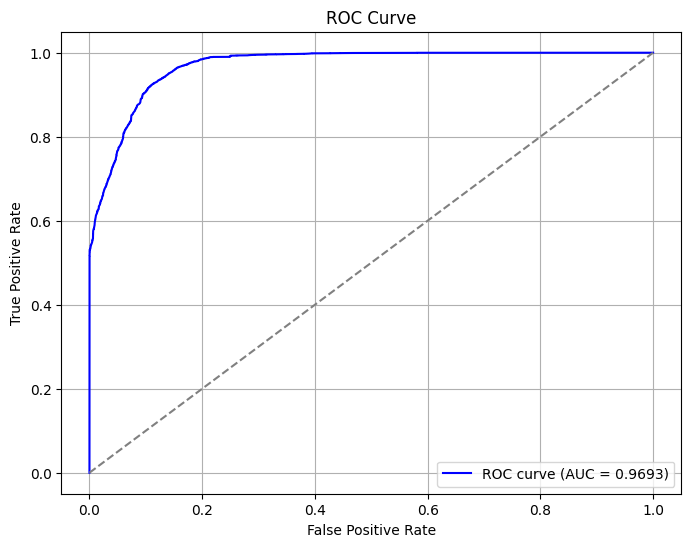

In [10]:
from sklearn.metrics import roc_curve, auc
import matplotlib.pyplot as plt

fpr, tpr, _ = roc_curve(y_test_int, y_pred_proba)
roc_auc = auc(fpr, tpr)

plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, color="blue", label=f"ROC curve (AUC = {roc_auc:.4f})")
plt.plot([0, 1], [0, 1], color="gray", linestyle="--")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curve")
plt.legend(loc="lower right")
plt.grid()
plt.show()


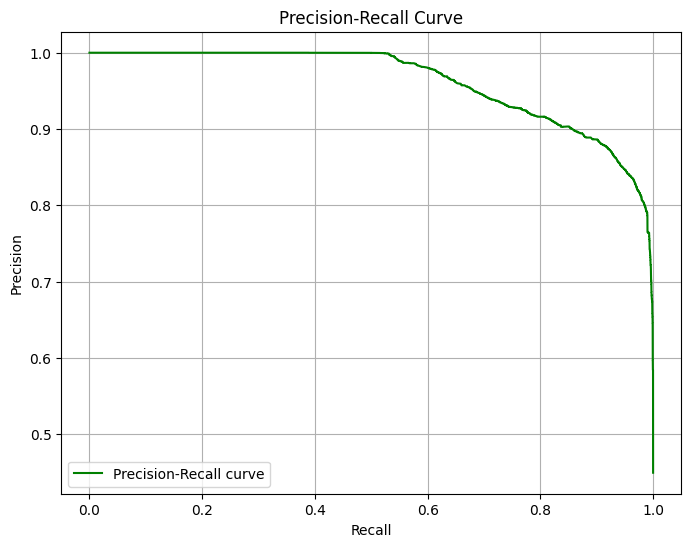

In [12]:
from sklearn.metrics import roc_curve, auc, precision_recall_curve

# Courbe Precision-Recall
precision, recall, _ = precision_recall_curve(y_test_int, y_pred_proba)

plt.figure(figsize=(8, 6))
plt.plot(recall, precision, color="green", label="Precision-Recall curve")
plt.xlabel("Recall")
plt.ylabel("Precision")
plt.title("Precision-Recall Curve")
plt.legend(loc="lower left")
plt.grid()
plt.show()

In [13]:
# tester le temps d'execution (latence) du modèle
import time

n_iter = 1000  # nombre de prédictions à chronométrer
start = time.time()

for _ in range(n_iter):
    _ = model.predict(X_test[:1], verbose=0)  # 1 ligne à la fois

end = time.time()
avg_time = (end - start) / n_iter
print(f"Temps moyen par prédiction : {avg_time:.6f} secondes")


Temps moyen par prédiction : 0.015500 secondes


In [14]:
# Tuning du seuil de prédiction
from sklearn.metrics import f1_score

best_thresh = 0.5
best_f1 = 0

for threshold in np.arange(0.1, 0.9, 0.01):
    y_pred = (y_pred_proba > threshold).astype(int)
    f1 = f1_score(y_test_int, y_pred)

    if f1 > best_f1:
        best_f1 = f1
        best_thresh = threshold

print(f"Seuil optimal = {best_thresh:.2f} avec F1-score = {best_f1:.4f}")


Seuil optimal = 0.47 avec F1-score = 0.8971
